In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib notebook
from scipy.signal.windows import dpss
from scipy.interpolate import interp1d
import torch

### 그냥 tlqkf 나중에 따로 공부해서 다시 시도하자

In [2]:
print(torch.__version__)

1.9.0+cu111


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
    print(device)

cuda


In [4]:
def make_U_cuda(H, time_step, device=device):
    """
    Convert the function to utilize PyTorch and run on a GPU.

    PARAMETERS
        H : Tensor of shape (4,4) representing the time-dependent Hamiltonian
        time_step : float, the time step for integration
        device : string, the device to run the calculations on ('cuda' for GPU or 'cpu' for CPU)

    RETURNS
        U : function of t, which computes the unitary time evolution operator U(t)
    """
    hbar = 1.  # Planck's constant (set to 1 for simplicity)
    I = torch.eye(4, dtype=torch.complex64, device=device)  # Identity matrix

    def U(t):
        total = I  # U(t=0)
        check = [I]
        times = torch.arange(start=0, end=t, step=time_step, device=device)
        for time in times:
            H(time).to(device)
            derivative = (-1j / hbar) * torch.matmul(H(time), total) * time_step
            total = total + derivative
            check.append(total) 
        return total, np.array(check)
    
    return U


In [5]:
def make_U(H, time_step, device='cuda'):
    """
    Convert the function to utilize PyTorch and run on a GPU.

    PARAMETERS
        H : Function that returns a Tensor of shape (4,4) representing the time-dependent Hamiltonian
        time_step : float, the time step for integration
        device : string, the device to run the calculations on ('cuda' for GPU or 'cpu' for CPU)

    RETURNS
        U : function of t, which computes the unitary time evolution operator U(t)
    """
    hbar = 1.  # Planck's constant (set to 1 for simplicity)
    I = torch.eye(4, dtype=torch.complex64, device=device)  # Identity matrix

    def U(t):
        total = I.clone()  # U(t=0)
        check = [I]
        times = torch.arange(start=0, end=t, step=time_step, device=device)
        for time in times:
            Ht = H(time).to(device)
            derivative = (-1j / hbar) * torch.matmul(Ht, total) * time_step
            total += derivative
            check.append(total)
        return total, check
    
    return U


In [6]:
def make_H_int(g,delta_omega):
    """
    
    :param g: coupling strength
    :param detuning: omega_q1 - omega_q2
    :return: 
    """
    
    def H_int(t):
        matrix = torch.zeros((4, 4), dtype=torch.complex64, device=device)
        matrix[2, 1] = torch.exp((1j) * delta_omega * t)
        matrix[1, 2] = torch.exp((-1j) * delta_omega * t)
        return g(t) * matrix

    
    return H_int

In [7]:
def make_H_d1(Omega,V_0,delta_omega,phi,s):
    """
    :param Omega:  
    :param V_0: 
    :param delta_omega:omega_q - omega_d 
    :param phi: offset in driving sine wave
    :param s: control pulse
    :return: 
    """
    I=torch.eye(2,dtype=torch.complex64)

    def H(t):
        matrix = torch.zeros((2,2),dtype=torch.complex64)
        matrix[0][1]=torch.exp(torch.tensor((1j)*(delta_omega*t+phi)))
        matrix[1][0]=torch.exp(torch.tensor((-1j)*(delta_omega*t+phi)))
    
        return (-0.5)*Omega*V_0*s(t)*torch.kron(matrix,I)
    
    return H #4by4 matrix

In [8]:
def make_H_d2(Omega,V_0,delta_omega,phi,s):
    """
    :param Omega:  
    :param V_0: 
    :param delta_omega:omega_q - omega_d 
    :param phi: offset in driving sine wave
    :param s: control pulse
    :return: 
    """
    I=torch.eye(2,dtype=torch.complex64)

    def H(t):
        matrix = torch.zeros((2,2),dtype=torch.complex64)
        matrix[0][1]=torch.exp(torch.tensor((1j)*(delta_omega*t+phi)))
        matrix[1][0]=torch.exp(torch.tensor((-1j)*(delta_omega*t+phi)))
    
        return (-0.5)*Omega*V_0*s(t)*torch.kron(I,matrix)
    
    return H #4by4 matrix

In [9]:
def g(t):
    return 0.04*2*np.pi 
# 40MHz

In [10]:
def s(t):
    return 1

In [11]:
def slepian(t):
    Fs = 10 #sampling rate 1ns에 10번 
    N = 500
    time = np.arange(N+1)/Fs 
    #freq = np.fft.fftfreq(N+1,d=1/Fs)
    NW = 6    # Time-halfbandwidth product
    # Generating the Slepian sequences
    slepian_sequence = dpss(N+1, NW)
    slepian_continuous = interp1d(time, slepian_sequence, kind='cubic')
    return slepian_continuous(t)

<IPython.core.display.Javascript object>


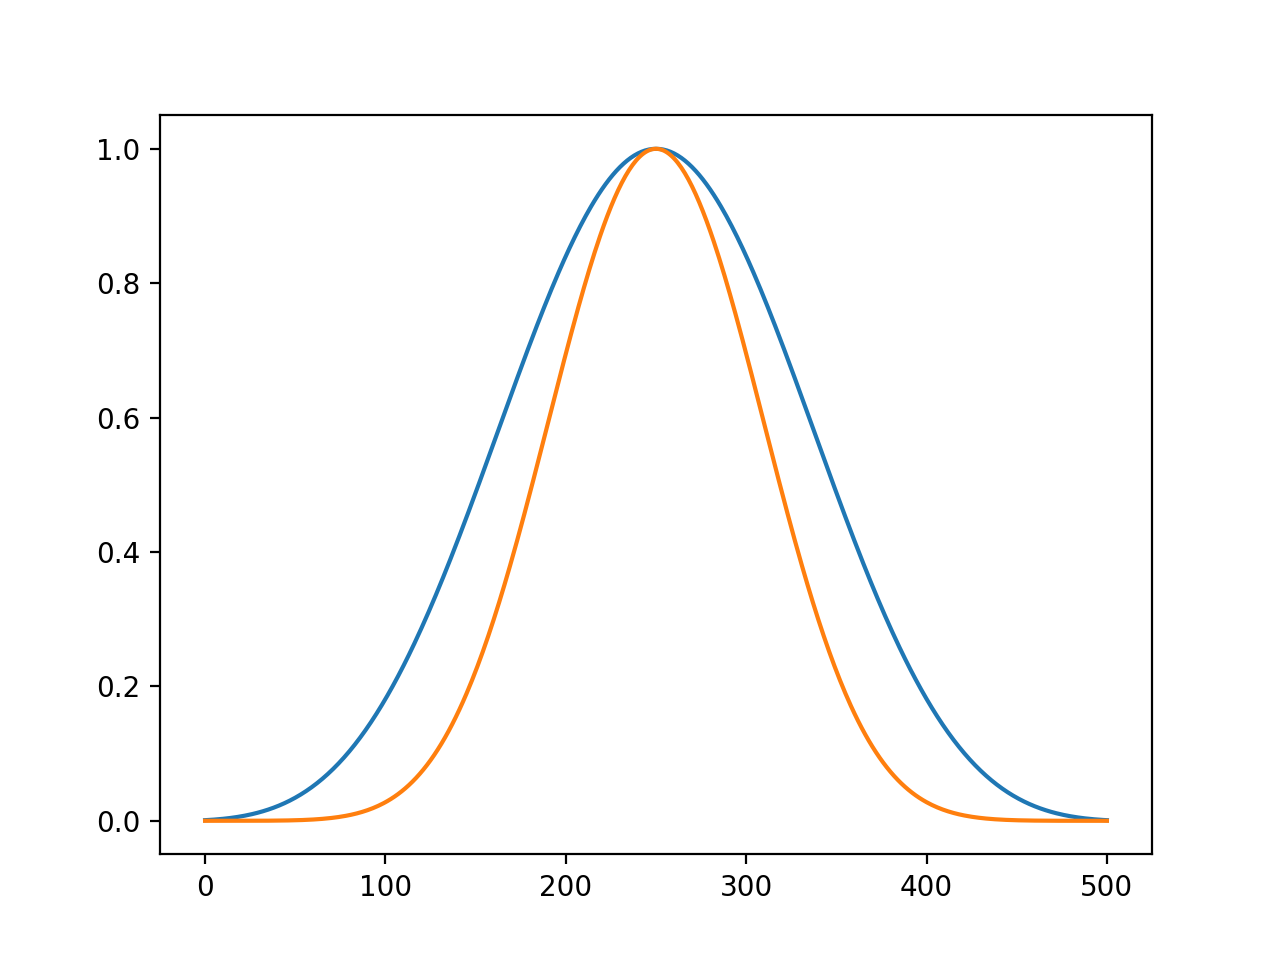

In [12]:
Fs = 10 #sampling rate 1ns에 10번 
N = 500
time = np.arange(N+1)/Fs 
    #freq = np.fft.fftfreq(N+1,d=1/Fs)
NW =  3   # Time-halfbandwidth product
    # Generating the Slepian sequences
slepian_sequence = dpss(N+1, NW)
slepian_sequence2 = dpss(N+1, 6)
fig, ax = plt.subplots()
ax.plot(slepian_sequence)
ax.plot(slepian_sequence2)

In [13]:
#Setting
omega1 = 0.01 * 2 * np.pi #10MHz
omega2 = 0.01 * 2 * np.pi #10MHz
V1=1.
V2=1. #unit?
delta_omega1 = 0.001 * 2 * np.pi #1MHz #qubit frequency and driving frequency
delta_omega2 = 0.001 * 2 * np.pi #1MHz
delta_q12 = 1 * 2 * np.pi # 1GHz
phi1 = 0.001
phi2 = 0.001

In [14]:
H_int = make_H_int(g=g,delta_omega=delta_omega2) 
H_d1 = make_H_d1(Omega=omega1, V_0=V1,delta_omega=delta_omega1,s=slepian,phi=phi1)
H_d2 = make_H_d2(Omega=omega2, V_0=V2,delta_omega=delta_omega2,s=slepian,phi=phi2)
def H(t):
    return H_int(t)+H_d1(t)+H_d2(t)

In [33]:
U = make_U(H, time_step=1e-4)

In [16]:
Uhigh = make_U(H, time_step=1e-5)

In [34]:
transition, info = U(50.) #한번 돌리는데 4분30초...GPU로 계산하면 더 빠른가?

/tmp/ipykernel_38780/3512693502.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix[0][1]=torch.exp(torch.tensor((1j)*(delta_omega*t+phi)))
/tmp/ipykernel_38780/3512693502.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix[1][0]=torch.exp(torch.tensor((-1j)*(delta_omega*t+phi)))


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [32]:
info[0]

tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]], device='cuda:0')

<IPython.core.display.Javascript object>


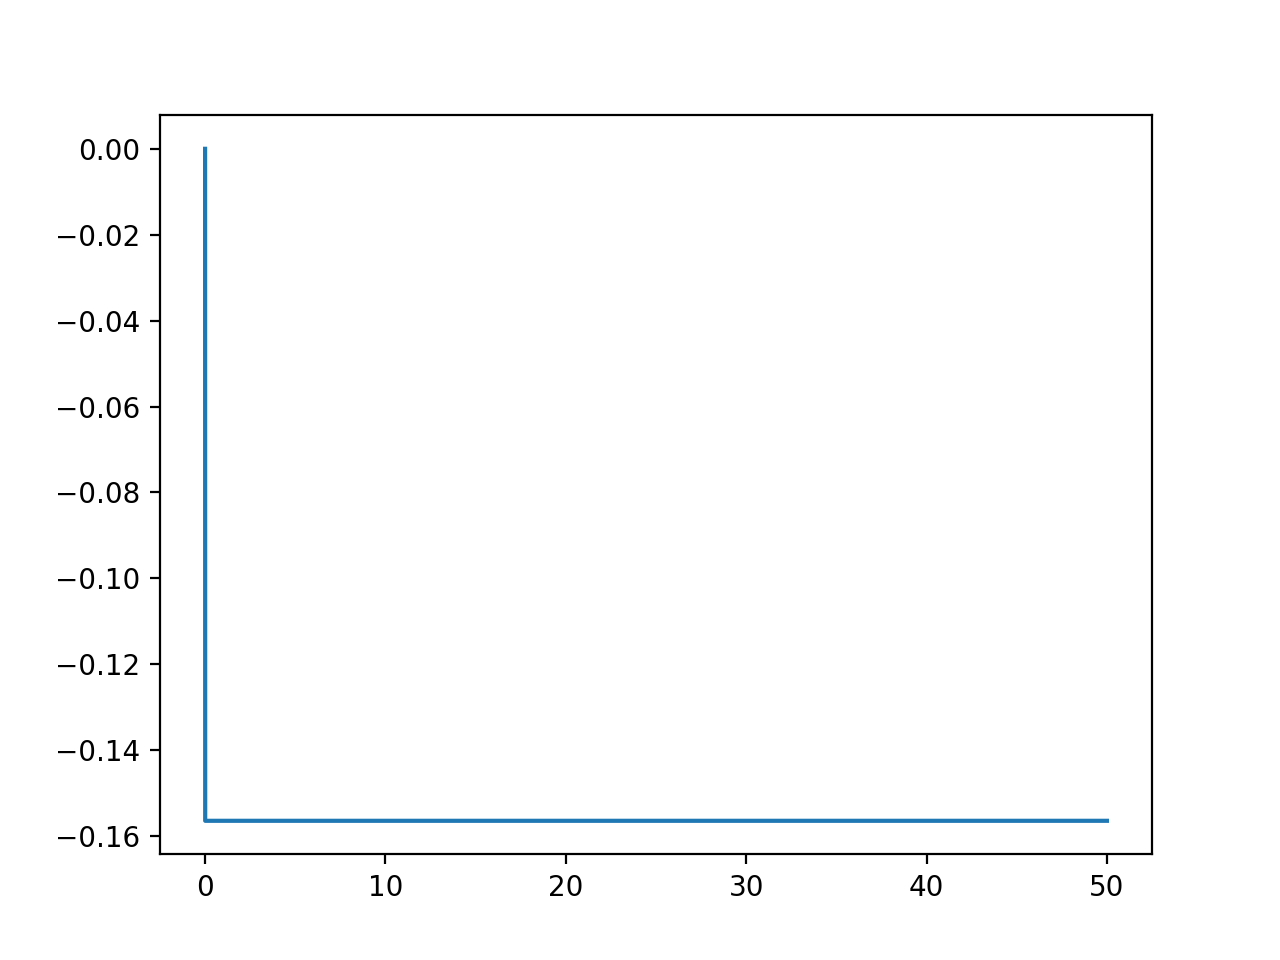

In [31]:
trajectories=[]
fig, ax = plt.subplots()
ax.plot(np.arange(start=0,stop=50.+1e-4,step=1e-4),[u.cpu()[1][1].imag for u in info])

In [ ]:
#prepare qubit 1 in e 
initial_state = np.array([0,0,1.,0,], dtype=complex)
desired_state = np.array([0,1.,0,0,], dtype=complex)

iSWAP=np.zeros((4,4),dtype=complex)
iSWAP[0,0]=1.
iSWAP[3,3]=1.
iSWAP[2,1]=-1j
iSWAP[1,2]=-1j


In [ ]:
trans_state=np.matmul(iSWAP,initial_state)
np.matmul(np.matrix.getH(desired_state),trans_state)

$$s_1(t),\ s_2(t), g(t)$$



In [ ]:
np.matrix.getH(desired_state)

In [ ]:
trans_state